In [1]:
import gc
import torch
from fastai.vision import *
from fastai.widgets import *
from fastai.callbacks import * 
import shutil
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.52
cuda: False


In [2]:
Config.DEFAULT_CONFIG = {
        'data_path': './../data/MURA-v1.1/',
        'model_path': './models/'
    }

Config.create('/tmp/myconfig.yml')
Config.DEFAULT_CONFIG_PATH = '/tmp/myconfig.yml'

path = Config.data_path()

In [6]:
size = 320
bs = 32

np.random.seed(24)
# data = ImageDataBunch.from_folder('../data/MURA-v1.1/data2/', ds_tfms=get_transforms(do_flip=True, max_rotate=30, max_warp=0.0, p_lighting=0, xtra_tfms=[cutout(n_holes=(0,3), length=(5,35),p=1)]), size=size, bs=bs).normalize(imagenet_stats)
#data = ImageDataBunch.from_df(path='../data/MURA-v1.1/data2/', df=pd.read_csv('all_elbows.csv'), ds_tfms=get_transforms(do_flip=True, max_rotate=30, max_warp=0.0, p_lighting=0, xtra_tfms=[]), size=size, bs=bs).normalize(imagenet_stats)
def create_from_ll(lls:LabelLists, bs:int=64, val_bs:int=None, ds_tfms:Optional[TfmList]=None,
                num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None, device:torch.device=None,
                test:Optional[PathOrStr]=None, collate_fn:Callable=data_collate, size:int=None, no_check:bool=False,
                resize_method:ResizeMethod=None, mult:int=None, padding_mode:str='reflection',
                mode:str='bilinear', tfm_y:bool=False)->'ImageDataBunch':
    "Create an `ImageDataBunch` from `LabelLists` `lls` with potential `ds_tfms`."
    lls = lls.transform(tfms=get_transforms(do_flip=True, max_rotate=30, max_warp=0.0, p_lighting=0, xtra_tfms=[]), size=size, resize_method=resize_method, mult=mult, padding_mode=padding_mode,
                        mode=mode, tfm_y=tfm_y)
    
    return lls.databunch(bs=bs, val_bs=bs, dl_tfms=dl_tfms, num_workers=num_workers, collate_fn=collate_fn,
                         device=device, no_check=True)

src = (ImageList.from_df(df=pd.read_csv('all_elbows.csv'), path='../data/MURA-v1.1/data2/', folder=None, suffix='', cols=0)
                .split_from_df("is_valid")
                .label_from_df(label_delim=None, cols=1))
data = create_from_ll(src, size = size, bs = bs).normalize(imagenet_stats)


kappa = KappaScore()
kappa.weights = "quadratic"





<class 'fastai.data_block.LabelLists'>


In [17]:
learner = cnn_learner(data, models.vgg19_bn, metrics=[error_rate, accuracy, kappa], wd=0.1, model_dir="./models/").to_fp32()
# #learner.unfreeze()
# learner.fit_one_cycle(5,max_lr=1e-3, callbacks=[ShowGraph(learner) ,SaveModelCallback(learner)])

learner.load('vgg19bn-elbowsfullval')
test = ImageList.from_df(df=pd.read_csv('all_elbows.csv'), path='../data/MURA-v1.1/data2/', folder=None, suffix='', cols=0)
df = pd.read_csv('all_elbows.csv')
print(df.loc[3000])
print(test[3000])
prediction = learner.predict(test[3000])
print(int(prediction[1]))

name        train/1/ELBOW_patient05336_study1_positive_ima...
value                                                       1
is_valid                                                False
Name: 3000, dtype: object
Image (3, 512, 512)
1


In [13]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

Traceback (most recent call last):
  File "/home/bibek/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/bibek/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/bibek/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/bibek/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/bibek/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/bibek/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/bibek/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(he

KeyboardInterrupt: 

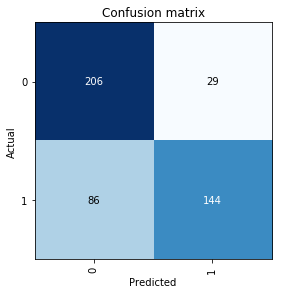

In [6]:
interp.plot_confusion_matrix()

In [15]:
df = pd.read_csv('all_elbows.csv')
names = list(df['name'])
print(names[0])
val = [i for i in names if 'valid' in i]
print(len(val))
print(len(df.index))


train/0/ELBOW_patient06252_study1_negative_image1.png
465
5396


In [ ]:
val_preds,val_targets = learner.get_preds() 

In [ ]:
print(float(val_preds[0][0]))

In [ ]:
from os import listdir
from os.path import isfile, join
files = [f for f in listdir('../data/MURA-v1.1/data2/valid/0/') if isfile(join('../data/MURA-v1.1/data2/valid/0/', f))]
files += [f for f in listdir('../data/MURA-v1.1/data2/valid/1/') if isfile(join('../data/MURA-v1.1/data2/valid/1/', f))]
files[0]

In [ ]:
studies = []
studies_labels = []
for file in files:
    study = file[:-11]
    if study not in studies:
        studies.append(study)
        if 'negative' in study:
            studies_labels.append(0)
        else:
            studies_labels.append(1)


In [ ]:
# learner.get_preds('../data/MURA-v1.1/data2/valid/0/ELBOW_patient11860_study1_negative_image1.png')

# img = open_image('../data/MURA-v1.1/data2/valid/0/ELBOW_patient11860_study1_negative_image1.png')
# img
# learner.predict(img)

print(len(val_preds))
print(len(files))

In [ ]:
studies_preds = []
file_count = 0
for study in studies:
    num_imgs = sum(1 for file in files if study in file)
    combined_pred = 0
    for i in range(num_imgs):
        combined_pred += float(val_preds[file_count][1])
        file_count += 1
    combined_pred = combined_pred/num_imgs
    
    if combined_pred >= 0.6:
        studies_preds.append(1)
    else:
        studies_preds.append(0)


In [ ]:
study_actual = dict()
for study in studies:
    if 'negative' in study:
        study_actual[study] = 0
    else:
        study_actual[study] = 1
    

In [ ]:
study_dict = dict()
for study in studies:
    if study not in study_dict:
        study_dict[study] = []

In [ ]:
file_count = 0
for file in files:
    study = file[:-11]
    study_dict[study].append(float(val_preds[file_count][1]))
    file_count += 1

In [ ]:
study_preds = dict()
for study in study_dict:
    combined_pr = sum(study_dict[study])/len(study_dict[study])
    if combined_pr >= 0.5:
        study_preds[study] = 1
    else:
        study_preds[study] = 0

In [ ]:
print(len(study_actual))
print(len(study_preds))

In [ ]:
please = 0
for i in study_actual:
    if study_actual[i] == study_preds[i]:
        please += 1

In [ ]:
please/1200

In [ ]:
#kappa
actual_list = []
pred_list = []
for i in study_actual:
    actual_list.append(study_actual[i])
    pred_list.append(study_preds[i])



In [ ]:
p_o = 0
p_e = 0

In [ ]:
agreed = 0
for i in range(len(actual_list)):
    if actual_list[i] == pred_list[i]:
        agreed += 1
p_o = agreed/len(actual_list)
p_o

In [ ]:
actual_yes = sum(actual_list)/len(actual_list)
pred_yes = sum(pred_list)/len(pred_list)

actual_no = 1-sum(actual_list)/len(actual_list)
pred_no = 1-sum(pred_list)/len(pred_list)

p_e = actual_yes*pred_yes + actual_no*pred_no
p_e

In [ ]:
kappa = (p_o-p_e)/(1-p_e)

In [ ]:
kappa